In [ ]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import pandas as pd
import numpy as np
from functools import reduce
import contextily as ctx
import datetime as dt
import math
import plotly.express as px
from scipy.stats import spearmanr

#Importing spatial libraries
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
# Read ACS data
df_full = pd.read_csv('/work/COVIDRedlining/data/ACS/acs_census_tract_2018_5yr.csv')
df_full.head()

,Unnamed: 0,geo_id,do_date,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,...,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english
0,0,72119130101,2014-01-01,4971.0,1612.0,2455.0,2516.0,39.2,155.0,144.0,...,379.0,362.0,197.0,192.0,357.0,1036.0,218.0,NaN,NaN,NaN
1,1,72127009624,2014-01-01,3876.0,1548.0,1554.0,2322.0,39.3,49.0,119.0,...,732.0,389.0,185.0,157.0,263.0,1124.0,323.0,NaN,NaN,NaN
2,2,72021031612,2014-01-01,4591.0,1607.0,2004.0,2587.0,27.9,240.0,250.0,...,359.0,356.0,342.0,263.0,236.0,1462.0,411.0,NaN,NaN,NaN
3,3,72127009111,2014-01-01,2584.0,1466.0,1076.0,1508.0,51.3,9.0,100.0,...,470.0,319.0,42.0,129.0,84.0,568.0,183.0,NaN,NaN,NaN
4,4,72025201000,2014-01-01,2037.0,910.0,784.0,1253.0,39.6,49.0,40.0,...,82.0,158.0,154.0,89.0,141.0,538.0,116.0,NaN,NaN,NaN


In [ ]:
df_full[df_full['geo_id']==25017353101]

,Unnamed: 0,geo_id,do_date,total_pop,households,male_pop,female_pop,median_age,male_under_5,male_5_to_9,...,management_business_sci_arts_employed,sales_office_employed,in_grades_1_to_4,in_grades_5_to_8,in_grades_9_to_12,in_school,in_undergrad_college,speak_only_english_at_home,speak_spanish_at_home,speak_spanish_at_home_low_english
53398,53398,25017353101,2014-01-01,2526.0,840.0,1246.0,1280.0,27.9,27.0,53.0,...,1206.0,129.0,46.0,56.0,32.0,1021.0,539.0,NaN,NaN,NaN


In [ ]:
boston_redline = gpd.read_file('/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson')
cambridge_redline = gpd.read_file('/work/COVIDRedlining/data/boston/cambridge_redlined_numerical_values.geojson')
df_redline = pd.concat([boston_redline, cambridge_redline])

In [ ]:
df_redline = df_redline[['GEOID','reweighted_redline_index', 'ordinal_value', 'geometry']]
df_redline.rename(columns = {'GEOID':'geo_id'}, inplace=True)
df = pd.merge(df_redline,
                 df_full,
                 on='geo_id', 
                 how='left')
df.shape

(239, 246)

In [ ]:
df.geometry

0      POLYGON ((-71.08560 42.34788, -71.08531 42.347...
1      POLYGON ((-71.10845 42.32239, -71.10798 42.322...
2      POLYGON ((-71.07921 42.34270, -71.07856 42.343...
3      POLYGON ((-71.13924 42.23366, -71.13841 42.234...
4      POLYGON ((-71.09208 42.30995, -71.09182 42.310...
                             ...                        
234    POLYGON ((-71.08805 42.37134, -71.08787 42.372...
235    POLYGON ((-71.10751 42.37268, -71.10718 42.373...
236    POLYGON ((-71.11391 42.37084, -71.11350 42.371...
237    POLYGON ((-71.11692 42.36425, -71.11638 42.364...
238    POLYGON ((-71.08943 42.36605, -71.08918 42.367...
Name: geometry, Length: 239, dtype: geometry

In [ ]:
from geopandas import GeoDataFrame

geometry = df['geometry']
gdf = GeoDataFrame(df, crs="EPSG:4326", geometry=geometry)
gdf.head()

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  after removing the cwd from sys.path.


ValueError: Can't clean for JSON: <shapely.geometry.polygon.Polygon object at 0x7ff750b9c210>

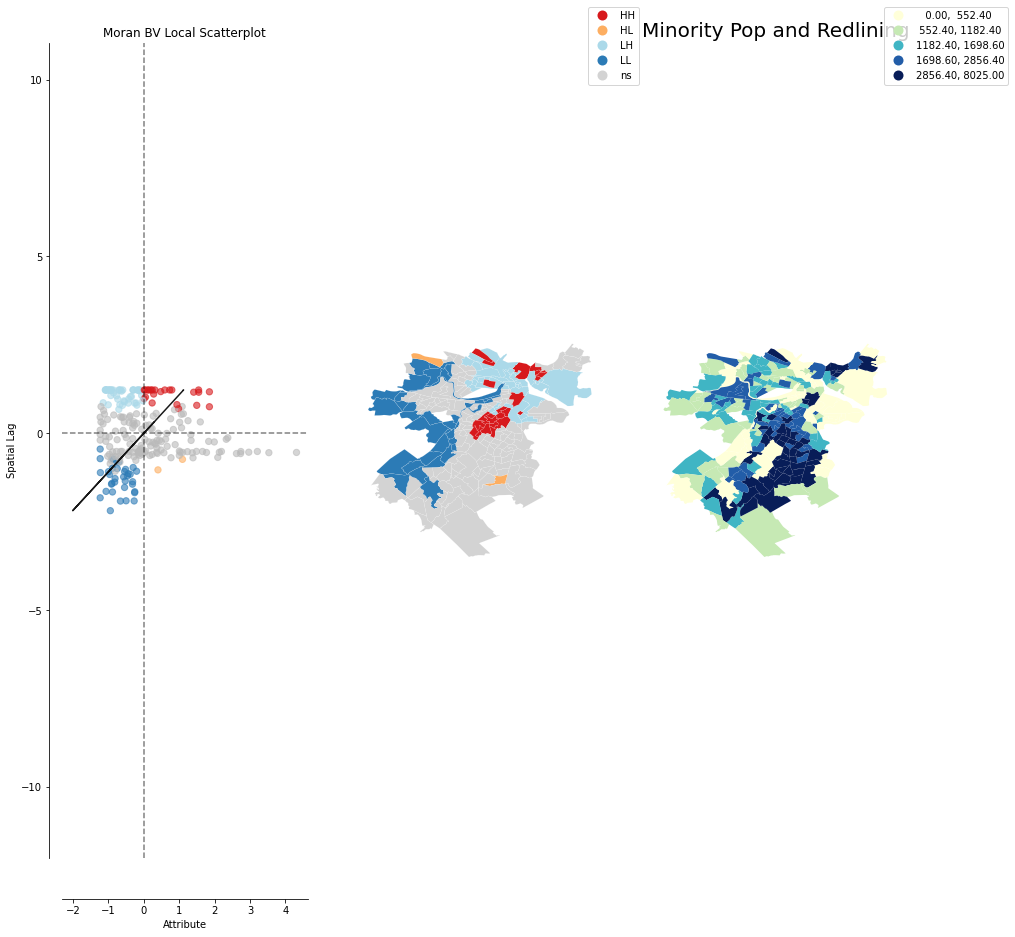

In [ ]:
#Creating spatial indices and running correlations

gdf['minority_pop'] = gdf['black_pop'] + gdf['asian_pop'] + gdf['hispanic_pop'] + gdf['amerindian_pop']

#Dropping null values
#gdf = gdf.dropna()

#Renaming columns 
gdf = gdf.rename(columns={'reweighted_redline_index':'redlining_index'})

#t = [25025061101.0,25025140106.0,25025060700.0]
#minority_svi_boston = minority_svi_boston.loc[~minority_svi_boston.geo_id.isin(t)]

#Spatial transformations
w = Queen.from_dataframe(gdf)
w.transform = 'R'

#Running spatial correlations
y = gdf['minority_pop'].values
x = gdf['redlining_index'].values
moran = Moran(y,w)
moran_loc = Moran_Local(y, w)
moran_bv = Moran_BV(y, x, w)
moran_loc_bv = Moran_Local_BV(y, x, w, permutations = 999)

plot_local_autocorrelation(moran_loc_bv, gdf, 'minority_pop', figsize=(15,15))
#Adding a column for cluster values
gdf['cluster'] = moran_loc_bv.q 
plt.title('Minority Pop and Redlining', fontdict={'fontsize':20})
plt.show()

In [ ]:
gdf['cluster']

0      2
1      2
2      2
3      3
4      4
      ..
234    2
235    2
236    2
237    2
238    1
Name: cluster, Length: 239, dtype: int64

In [ ]:
moran.I

0.4561439796682124

In [ ]:
# Create 4 new SVI variables from ACS variables 
gdf['aged_65_or_older'] = gdf['female_65_to_66'] + gdf['female_67_to_69'] + gdf['female_70_to_74'] + gdf['female_75_to_79'] + gdf['female_80_to_84'] + gdf['female_85_and_over'] + gdf['male_65_to_66'] + gdf['male_67_to_69'] + gdf['male_70_to_74'] + gdf['male_75_to_79'] + gdf['male_80_to_84'] + gdf['male_85_and_over']
gdf['aged_17_or_younger'] = gdf['female_under_5'] + gdf['female_5_to_9'] + gdf['female_10_to_14'] + gdf['female_15_to_17'] + gdf['male_under_5'] + gdf['male_5_to_9'] + gdf['male_10_to_14'] + gdf['male_15_to_17']
gdf['multi_unit_structures'] = gdf['dwellings_10_to_19_units'] + gdf['dwellings_20_to_49_units'] + gdf['dwellings_50_or_more_units']

# Non-white
gdf['non_white'] = gdf['total_pop'] - gdf['white_pop']

In [ ]:
def perc_bin(x):
    
    if x > 0 and x <= 0.1:
      val = 1
    elif x > 0.1 and x <= 0.2:
      val = 2
    elif x > 0.2 and x <= 0.3:
      val = 3
    elif x > 0.3 and x <= 0.4:
      val = 4
    elif x > 0.4 and x <= 0.5:
      val = 5
    elif x > 0.5 and x <= 0.6:
      val = 6
    elif x > 0.6 and x <= 0.7:
      val = 7
    elif x > 0.7 and x <= 0.8:
      val = 8
    elif x > 0.8 and x <= 0.9:
      val = 9
    elif x > 0.9 and x <= 1:
      val = 10
    else:
      val = 0

    return val

In [ ]:
# Define a set variables selected based on SVI, for the purpose of data cleaning
SVI_Vars = ['geo_id','cluster','poverty','unemployed_pop','median_income','income_per_capita','less_than_high_school_graduate',
'aged_65_or_older','aged_17_or_younger','one_parent_families_with_young_children',
'non_white','multi_unit_structures','mobile_homes','no_cars','group_quarters',
'pop_determined_poverty_status','total_pop','households','housing_units', 'redlining_index','ordinal_value']

In [ ]:
#Preserve Boston Geodataframe
gdf_Boston = gdf.copy()
gdf_Boston.head()

ValueError: Can't clean for JSON: <shapely.geometry.polygon.Polygon object at 0x7ff744772e50>

In [ ]:
#Subsetting SVI variables
gdf_Boston = gdf_Boston[SVI_Vars]
gdf_Boston.head()

,geo_id,cluster,poverty,unemployed_pop,median_income,income_per_capita,less_than_high_school_graduate,aged_65_or_older,aged_17_or_younger,one_parent_families_with_young_children,...,multi_unit_structures,mobile_homes,no_cars,group_quarters,pop_determined_poverty_status,total_pop,households,housing_units,redlining_index,ordinal_value
0,2.502501e+10,2,399.0,48.0,93214.0,125222.0,55.0,689.0,138.0,54.0,...,2482.0,0.0,1102.0,0.0,3145.0,3145.0,2008.0,2693.0,3.904488,4
1,2.502512e+10,2,547.0,145.0,81250.0,39658.0,126.0,238.0,402.0,59.0,...,120.0,0.0,317.0,0.0,2750.0,2817.0,1024.0,1056.0,3.725805,4
2,2.502507e+10,2,153.0,29.0,154659.0,122822.0,29.0,294.0,402.0,0.0,...,41.0,0.0,303.0,6.0,2559.0,2559.0,1177.0,1241.0,4.000000,4
3,2.502514e+10,3,246.0,30.0,71125.0,33013.0,264.0,361.0,453.0,73.0,...,221.0,0.0,81.0,7.0,2475.0,2475.0,929.0,995.0,3.000000,3
4,2.502508e+10,4,2062.0,281.0,20386.0,20995.0,713.0,857.0,1350.0,293.0,...,905.0,0.0,1242.0,18.0,5726.0,5750.0,2298.0,2377.0,3.000000,3


In [ ]:
#Merging with geo file for spatial analysis

import geopandas as gpd
#Loading MASS geofile
boston_geodf = gpd.read_file('/work/COVIDRedlining/data/boston/boston census tracts/tl_2019_25_tract.shp')

#Taking only geo-values for boston
boston_geoid = list(df_redline['geo_id'])

#Renaming columns 
boston_geodf = boston_geodf.rename(columns={'GEOID':'geo_id'})

#Converting data types
boston_geodf['geo_id'] = boston_geodf['geo_id'].astype(float) 

#Subsetting only boston valyes
boston_geodf = boston_geodf.loc[boston_geodf['geo_id'].isin(boston_geoid)]

#Merging SVI with geo df 
gdf_Boston = boston_geodf.merge(gdf_Boston, on ='geo_id', how ='left')
gdf_Boston.head()

ValueError: Can't clean for JSON: <shapely.geometry.polygon.Polygon object at 0x7ff744790490>

In [ ]:
#Making a copy of the Boston data to use for subsetting minority populations later
svi_boston_minority = gdf_Boston.copy()

#Making a copy of the Boston data to use for creating SVI variables for all census tracts
svi_boston = gdf_Boston.copy()

#Creating SVI variables for all census tracts
svi_boston['poverty_perc'] = svi_boston['poverty']/svi_boston['pop_determined_poverty_status']
svi_boston['poverty_perc_bin'] = svi_boston['poverty_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['poverty_perc'] >= svi_boston['poverty_perc'].quantile(0.9), 'poverty_flag'] = 1
svi_boston['poverty_flag'] = svi_boston['poverty_flag'].fillna(0)

svi_boston['unemployed_pop_perc'] = svi_boston['unemployed_pop'] / svi_boston['total_pop']
svi_boston['unemployed_pop_perc_bin'] = svi_boston['unemployed_pop_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['unemployed_pop_perc'] >= svi_boston['unemployed_pop_perc'].quantile(0.9), 'unemployed_flag'] = 1
svi_boston['unemployed_flag'] = svi_boston['unemployed_flag'].fillna(0)

svi_boston['less_than_high_school_graduate_perc'] = svi_boston['less_than_high_school_graduate'] / svi_boston['total_pop']
svi_boston['less_than_high_school_graduate_perc_bin'] = svi_boston['less_than_high_school_graduate_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['less_than_high_school_graduate_perc'] >= svi_boston['less_than_high_school_graduate_perc'].quantile(0.9), 'less_than_high_school_graduate_flag'] = 1
svi_boston['less_than_high_school_graduate_flag'] = svi_boston['less_than_high_school_graduate_flag'].fillna(0)

svi_boston['aged_65_or_older_perc'] = svi_boston['aged_65_or_older'] / svi_boston['total_pop']
svi_boston['aged_65_or_older_perc_bin'] = svi_boston['aged_65_or_older_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['aged_65_or_older_perc'] >= svi_boston['aged_65_or_older_perc'].quantile(0.9), 'aged_65_or_older_flag'] = 1
svi_boston['aged_65_or_older_flag'] = svi_boston['aged_65_or_older_flag'].fillna(0)

svi_boston['aged_17_or_younger_perc'] = svi_boston['aged_17_or_younger'] / svi_boston['total_pop']
svi_boston['aged_17_or_younger_perc_bin'] = svi_boston['aged_17_or_younger_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['aged_17_or_younger_perc'] >= svi_boston['aged_17_or_younger_perc'].quantile(0.9), 'aged_17_or_younger_flag'] = 1
svi_boston['aged_17_or_younger_flag'] = svi_boston['aged_17_or_younger_flag'].fillna(0)

svi_boston['non_white_perc'] = svi_boston['non_white'] / svi_boston['total_pop']
svi_boston['non_white_perc_bin'] = svi_boston['non_white_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['non_white_perc'] >= svi_boston['non_white_perc'].quantile(0.9), 'non_white_flag'] = 1
svi_boston['non_white_flag'] = svi_boston['non_white_flag'].fillna(0)

svi_boston['one_parent_families_with_young_children_perc'] = svi_boston['one_parent_families_with_young_children'] / svi_boston['households']
svi_boston['one_parent_families_with_young_children_perc_bin'] = svi_boston['one_parent_families_with_young_children_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['one_parent_families_with_young_children_perc'] >= svi_boston['one_parent_families_with_young_children_perc'].quantile(0.9), 'one_parent_families_with_young_children_flag'] = 1
svi_boston['one_parent_families_with_young_children_flag'] = svi_boston['one_parent_families_with_young_children_flag'].fillna(0)

svi_boston['multi_unit_structures_perc'] = svi_boston['multi_unit_structures'] / svi_boston['housing_units']
svi_boston['multi_unit_structures_perc_bin'] = svi_boston['multi_unit_structures_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['multi_unit_structures_perc'] >= svi_boston['multi_unit_structures_perc'].quantile(0.9), 'multi_unit_structures_flag'] = 1
svi_boston['multi_unit_structures_flag'] = svi_boston['multi_unit_structures_flag'].fillna(0)

svi_boston['mobile_homes_perc'] = svi_boston['mobile_homes'] / svi_boston['housing_units']
svi_boston['mobile_homes_perc_bin'] = svi_boston['mobile_homes_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['mobile_homes_perc'] >= svi_boston['mobile_homes_perc'].quantile(0.9), 'mobile_homes_flag'] = 1
svi_boston['mobile_homes_flag'] = svi_boston['mobile_homes_flag'].fillna(0)

svi_boston['no_cars_perc'] = svi_boston['no_cars'] / svi_boston['households']
svi_boston['no_cars_perc_bin'] = svi_boston['no_cars_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['no_cars_perc'] >= svi_boston['no_cars_perc'].quantile(0.9), 'no_cars_flag'] = 1
svi_boston['no_cars_flag'] = svi_boston['no_cars_flag'].fillna(0)

svi_boston['group_quarters_perc'] = svi_boston['group_quarters'] / svi_boston['total_pop']
svi_boston['group_quarters_perc_bin'] = svi_boston['group_quarters_perc'].apply(perc_bin)
svi_boston.loc[svi_boston['group_quarters_perc'] >= svi_boston['group_quarters_perc'].quantile(0.9), 'group_quarters_flag'] = 1
svi_boston['group_quarters_flag'] = svi_boston['group_quarters_flag'].fillna(0)

In [ ]:
# Setting flags for the tracts which are ranked at 90th percentile and above

svi_boston.loc[svi_boston['median_income'] <= svi_boston['median_income'].quantile(0.1), 'median_income_flag'] = 1
svi_boston['median_income_flag'] = svi_boston['median_income_flag'].fillna(0)

svi_boston.loc[svi_boston['income_per_capita'] <= svi_boston['income_per_capita'].quantile(0.1), 'income_per_capita_flag'] = 1
svi_boston['income_per_capita_flag'] = svi_boston['income_per_capita_flag'].fillna(0)

In [ ]:
# The number of flags (for each tract), all SVI-based variables
svi_boston['SVI'] = svi_boston['poverty_flag'] + svi_boston['unemployed_flag'] + svi_boston['median_income_flag'] + svi_boston['income_per_capita_flag'] + svi_boston['less_than_high_school_graduate_flag'] + svi_boston['aged_65_or_older_flag'] + svi_boston['aged_17_or_younger_flag'] + svi_boston['one_parent_families_with_young_children_flag'] + svi_boston['non_white_flag'] + svi_boston['multi_unit_structures_flag'] + svi_boston['mobile_homes_flag'] + svi_boston['no_cars_flag'] + svi_boston['group_quarters_flag']

# The number of flags (for each tract); Theme#1: Socioeconomic Status
svi_boston['SVI_1'] = svi_boston['poverty_flag'] + svi_boston['unemployed_flag'] + svi_boston['median_income_flag'] + svi_boston['income_per_capita_flag'] + svi_boston['less_than_high_school_graduate_flag']

# The number of flags (for each tract); Theme#2: Household Composition & Disability
svi_boston['SVI_2'] = svi_boston['aged_65_or_older_flag'] + svi_boston['aged_17_or_younger_flag'] + svi_boston['one_parent_families_with_young_children_flag']

# The number of flags (for each tract); Theme#3: Minority Status & Language
svi_boston['SVI_3'] = svi_boston['non_white_flag']

# The number of flags (for each tract); Theme#4: Housing Type & Transportation
svi_boston['SVI_4'] = svi_boston['multi_unit_structures_flag'] + svi_boston['mobile_homes_flag'] + svi_boston['no_cars_flag'] + svi_boston['group_quarters_flag']

In [ ]:
svi_boston[['redlining_index','SVI','SVI_1','SVI_2','SVI_3','SVI_4','poverty_perc','unemployed_pop_perc','less_than_high_school_graduate_perc','aged_65_or_older_perc','aged_17_or_younger_perc','one_parent_families_with_young_children_perc','multi_unit_structures_perc','mobile_homes_perc','no_cars_perc','group_quarters_perc','median_income','income_per_capita']][svi_boston['cluster']==1].describe()

,redlining_index,SVI,SVI_1,SVI_2,SVI_3,SVI_4,poverty_perc,unemployed_pop_perc,less_than_high_school_graduate_perc,aged_65_or_older_perc,aged_17_or_younger_perc,one_parent_families_with_young_children_perc,multi_unit_structures_perc,mobile_homes_perc,no_cars_perc,group_quarters_perc,median_income,income_per_capita
count,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
mean,3.847057,3.000000,1.658537,0.512195,0.195122,0.634146,0.308014,0.052409,0.144664,0.096004,0.194243,0.098060,0.329276,0.001602,0.448646,0.094362,44765.097561,29472.804878
std,0.288752,2.236068,1.542883,0.675350,0.401218,0.968403,0.130424,0.026378,0.069583,0.040750,0.088363,0.068716,0.266263,0.004249,0.125483,0.175586,24989.858878,19852.166842
min,3.001516,0.000000,0.000000,0.000000,0.000000,0.000000,0.080019,0.013968,0.013977,0.019912,0.012587,0.000000,0.000000,0.000000,0.235314,0.000000,12759.000000,9436.000000
25%,3.820468,1.000000,0.000000,0.000000,0.000000,0.000000,0.197890,0.035143,0.099149,0.075217,0.123015,0.046044,0.119792,0.000000,0.368762,0.002179,24958.000000,16937.000000
50%,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.285317,0.045636,0.137997,0.088353,0.200997,0.101036,0.201599,0.000000,0.436232,0.010531,38750.000000,23489.000000
75%,4.000000,5.000000,3.000000,1.000000,0.000000,1.000000,0.411491,0.057323,0.186931,0.115760,0.247860,0.144917,0.567204,0.000000,0.523324,0.081818,54844.000000,32804.000000
max,4.000000,8.000000,5.000000,2.000000,1.000000,4.000000,0.573038,0.133786,0.295042,0.208659,0.348375,0.245627,0.928462,0.021492,0.788392,0.754223,103008.000000,93868.000000


In [ ]:
svi_boston[['redlining_index','SVI','SVI_1','SVI_2','SVI_3','SVI_4','poverty_perc','unemployed_pop_perc','less_than_high_school_graduate_perc','aged_65_or_older_perc','aged_17_or_younger_perc','one_parent_families_with_young_children_perc','multi_unit_structures_perc','mobile_homes_perc','no_cars_perc','group_quarters_perc','median_income','income_per_capita']][svi_boston['cluster']==2].describe()

,redlining_index,SVI,SVI_1,SVI_2,SVI_3,SVI_4,poverty_perc,unemployed_pop_perc,less_than_high_school_graduate_perc,aged_65_or_older_perc,aged_17_or_younger_perc,one_parent_families_with_young_children_perc,multi_unit_structures_perc,mobile_homes_perc,no_cars_perc,group_quarters_perc,median_income,income_per_capita
count,69.000000,69.000000,69.000000,69.000000,69.0,69.000000,66.000000,67.000000,67.000000,67.000000,67.000000,66.000000,66.000000,66.000000,66.000000,67.000000,66.000000,67.000000
mean,3.784622,0.608696,0.188406,0.115942,0.0,0.304348,0.139865,0.025515,0.061171,0.107327,0.115765,0.030239,0.361047,0.000539,0.338689,0.045951,94655.818182,61802.134328
std,0.374948,1.060208,0.600866,0.322501,0.0,0.601575,0.096021,0.017198,0.052884,0.049837,0.062220,0.038965,0.271444,0.001930,0.153686,0.165461,30665.031128,25576.185071
min,2.870276,0.000000,0.000000,0.000000,0.0,0.000000,0.024294,0.000000,0.000000,0.000000,0.000000,0.000000,0.009166,0.000000,0.073205,0.000000,20000.000000,6868.000000
25%,3.760747,0.000000,0.000000,0.000000,0.0,0.000000,0.080752,0.013705,0.023990,0.075743,0.071064,0.000000,0.156442,0.000000,0.234355,0.000000,71944.000000,43174.500000
50%,4.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.118908,0.023611,0.045316,0.103688,0.109124,0.016393,0.273368,0.000000,0.316786,0.004612,98927.000000,58214.000000
75%,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.171208,0.034261,0.077748,0.128032,0.147106,0.043484,0.529646,0.000000,0.468456,0.014192,116040.750000,76082.000000
max,4.000000,6.000000,3.000000,1.000000,0.0,3.000000,0.526606,0.079818,0.241767,0.274713,0.320764,0.172673,0.989653,0.011851,0.734007,1.000000,157222.000000,125222.000000


In [ ]:
svi_boston[['redlining_index','SVI','SVI_1','SVI_2','SVI_3','SVI_4','poverty_perc','unemployed_pop_perc','less_than_high_school_graduate_perc','aged_65_or_older_perc','aged_17_or_younger_perc','one_parent_families_with_young_children_perc','multi_unit_structures_perc','mobile_homes_perc','no_cars_perc','group_quarters_perc','median_income','income_per_capita']][svi_boston['cluster']==3].describe()

,redlining_index,SVI,SVI_1,SVI_2,SVI_3,SVI_4,poverty_perc,unemployed_pop_perc,less_than_high_school_graduate_perc,aged_65_or_older_perc,aged_17_or_younger_perc,one_parent_families_with_young_children_perc,multi_unit_structures_perc,mobile_homes_perc,no_cars_perc,group_quarters_perc,median_income,income_per_capita
count,78.000000,78.000000,78.000000,78.000000,78.0,78.000000,73.000000,73.000000,73.000000,73.000000,73.000000,72.000000,72.000000,72.000000,72.000000,73.000000,71.000000,73.000000
mean,2.715978,0.820513,0.166667,0.256410,0.0,0.397436,0.120680,0.031430,0.039253,0.144514,0.140107,0.026692,0.299163,0.000947,0.248609,0.088548,97285.619718,57744.095890
std,0.507777,1.224677,0.632798,0.468096,0.0,0.726846,0.119427,0.026201,0.053400,0.084909,0.077147,0.055562,0.254716,0.004118,0.183442,0.187005,33548.510923,27330.535496
min,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.003041,0.000000,0.003264,0.000816,0.000000,0.007426,0.000000,0.017094,0.000000,29946.000000,7017.000000
25%,2.508776,0.000000,0.000000,0.000000,0.0,0.000000,0.051191,0.019882,0.009422,0.091978,0.070872,0.000000,0.083772,0.000000,0.090004,0.001201,75330.500000,40801.000000
50%,2.992867,0.000000,0.000000,0.000000,0.0,0.000000,0.092489,0.025463,0.025186,0.139755,0.154795,0.009432,0.220446,0.000000,0.204930,0.010417,93920.000000,51714.000000
75%,3.000000,1.000000,0.000000,0.000000,0.0,1.000000,0.139907,0.037135,0.051101,0.181135,0.202357,0.028277,0.493902,0.000000,0.367771,0.054665,116735.000000,67958.000000
max,3.805856,6.000000,3.000000,2.000000,0.0,3.000000,0.806167,0.192308,0.413158,0.653846,0.308675,0.416667,0.932745,0.030763,0.739551,1.000000,180694.000000,153108.000000


In [ ]:
svi_boston[['redlining_index','SVI','SVI_1','SVI_2','SVI_3','SVI_4','poverty_perc','unemployed_pop_perc','less_than_high_school_graduate_perc','aged_65_or_older_perc','aged_17_or_younger_perc','one_parent_families_with_young_children_perc','multi_unit_structures_perc','mobile_homes_perc','no_cars_perc','group_quarters_perc','median_income','income_per_capita']][svi_boston['cluster']==4].describe()

,redlining_index,SVI,SVI_1,SVI_2,SVI_3,SVI_4,poverty_perc,unemployed_pop_perc,less_than_high_school_graduate_perc,aged_65_or_older_perc,aged_17_or_younger_perc,one_parent_families_with_young_children_perc,multi_unit_structures_perc,mobile_homes_perc,no_cars_perc,group_quarters_perc,median_income,income_per_capita
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,3.076829,1.529412,0.490196,0.431373,0.313725,0.294118,0.209491,0.047940,0.103005,0.107959,0.202128,0.100727,0.223228,0.001295,0.304093,0.047812,58993.372549,30432.627451
std,0.261845,1.641377,0.809260,0.700140,0.468623,0.641689,0.094268,0.023391,0.050044,0.034842,0.072426,0.071321,0.230843,0.003906,0.144927,0.153650,20315.985341,9877.044886
min,2.456926,0.000000,0.000000,0.000000,0.000000,0.000000,0.053619,0.003679,0.003279,0.001967,0.014590,0.000000,0.000000,0.000000,0.046778,0.000000,20386.000000,14075.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.144312,0.030174,0.073011,0.094430,0.164509,0.040983,0.061866,0.000000,0.210591,0.000868,45399.500000,22916.000000
50%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.201070,0.047869,0.111620,0.113469,0.213784,0.110317,0.136852,0.000000,0.297221,0.005601,53523.000000,28138.000000
75%,3.002836,3.000000,1.000000,1.000000,1.000000,0.000000,0.265271,0.064686,0.140113,0.127353,0.255077,0.146110,0.319639,0.000000,0.361633,0.017936,72746.500000,36687.500000
max,3.963529,6.000000,3.000000,2.000000,1.000000,3.000000,0.521448,0.109977,0.217175,0.166388,0.308430,0.268792,0.946690,0.018809,0.746881,0.833279,107333.000000,56220.000000


In [ ]:
#1 = (HH), 2 = (HL), 3 = (LH), 4 = (LL) where HH = High SVI, High Redlining, LH = Low SVI, High Redline


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>